In [1]:
import warnings

import pandas as pd
import numpy as np

#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
# Nomralization,standardisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#estimators
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#cross selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings(action="once")

In [3]:
df = pd.read_excel('Data/Data_2013-2022.xlsx')

In [4]:
def confusion(y_test, y_pred) : 
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

In [5]:
def score(estimator) :
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)

    print(f"score train : {tr_score} score test : {te_score} ")

# 1. Data preparation

In [6]:
#Shuffle data
df = df.sample(frac=1,random_state=1).reset_index(drop=True)

In [7]:
df = df.drop(columns=["Race","Year"])

In [8]:
#Checking correlation between columns
print(df.corr()["Breakaway win"].abs().sort_values(ascending=False))

Breakaway win             1.000000
Stage classification      0.409890
elevation gain            0.390591
KM last climb - finish    0.342084
Nbr 2 cat                 0.281083
Nbr 1 cat/HC              0.254558
Nbr 3 cat                 0.210351
Stage nbr                 0.198722
Nbr 4 cat                 0.182892
length                    0.031045
Name: Breakaway win, dtype: float64


In [9]:
X = df.drop(columns="Breakaway win")
y = df["Breakaway win"]

In [162]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(505, 9) (505,) (57, 9) (57,)


In [86]:
scaler = MinMaxScaler() 
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 2. Modelisation

## 2.1 Dummy classifier

In [206]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [207]:
cv_results['test_score']

array([0.63313609, 0.63690476, 0.63690476])

In [208]:
cv_results['test_score'].mean()

0.6356485394946932

In [209]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [210]:
sum(test_score) / len(test_score)

0.5087719298245614

In [211]:
score(estimator)

score train : 0.6356 score test : 0.5088 


In [212]:
y_pred = estimator.predict(X_test)

In [213]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,29,0
test_1,28,0


In [214]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

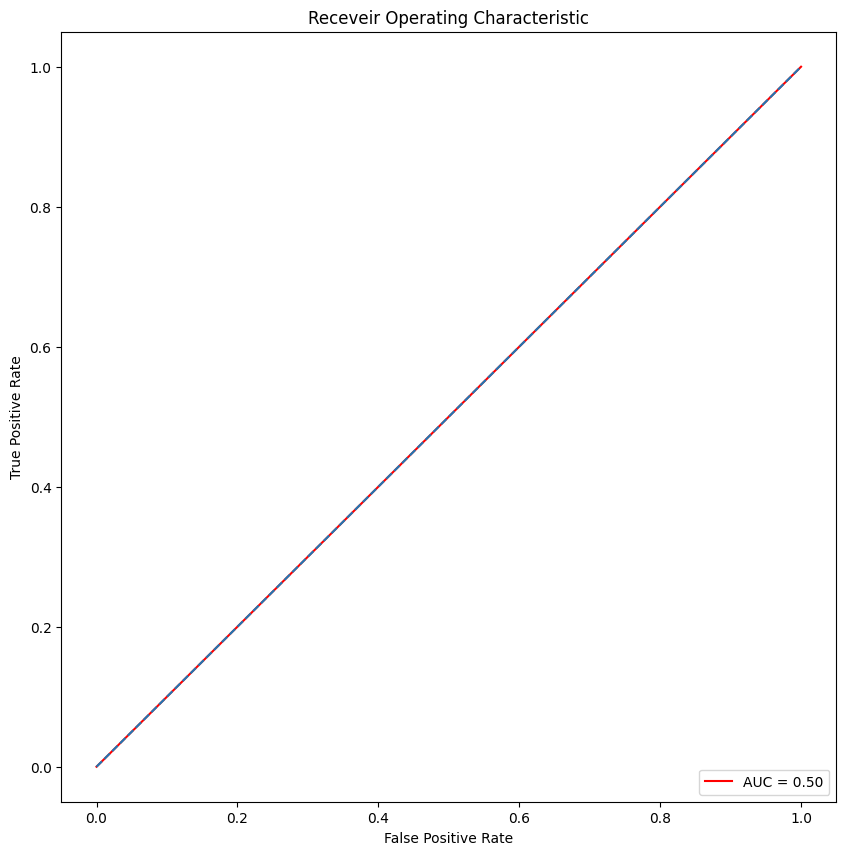

In [215]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.2 Logistic regression

Better result without Normalization

In [163]:
estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [164]:
cv_results['test_score']

array([0.68047337, 0.66071429, 0.69047619])

In [165]:
cv_results['test_score'].mean()

0.6772212829905137

In [166]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [167]:
sum(test_score) / len(test_score)

0.6549707602339181

In [168]:
score(estimator)

score train : 0.7149 score test : 0.7018 


In [169]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [170]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,24,5
test_1,12,16


In [171]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6995073891625616

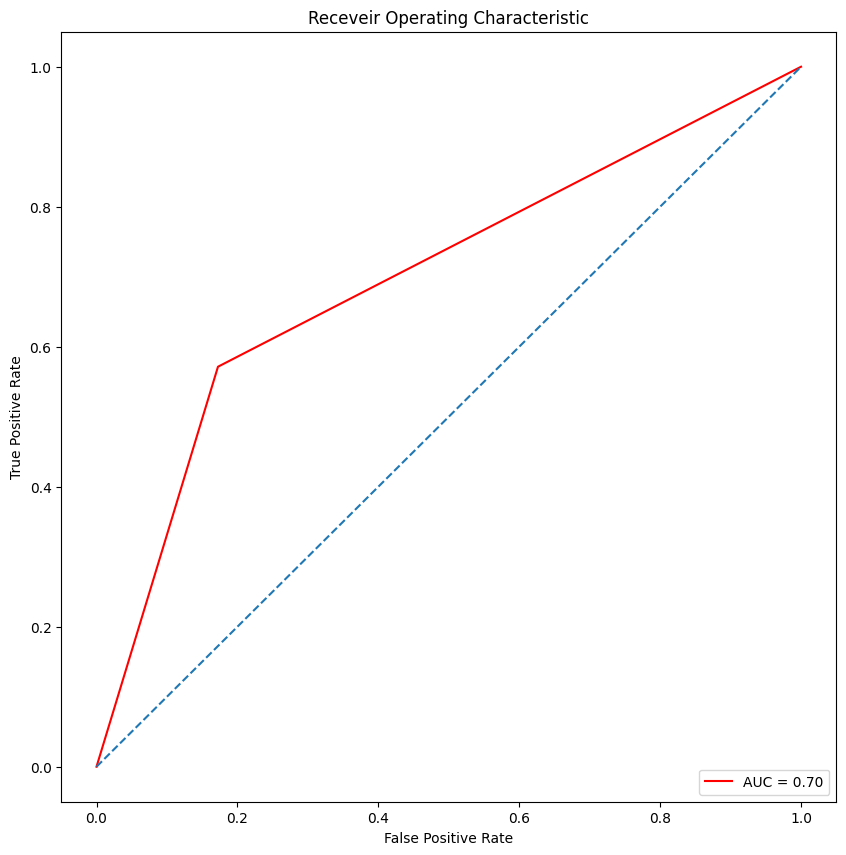

In [172]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 2.3 SVM

Better result after Normalization

In [107]:
estimator = LinearSVC(dual=False)

In [108]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [109]:
cv_results['test_score']

array([0.66272189, 0.69047619, 0.68452381])

In [110]:
cv_results['test_score'].mean()

0.679240631163708

In [111]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [112]:
sum(test_score) / len(test_score)

0.6374269005847953

In [114]:
score(estimator)

score train : 0.703 score test : 0.6842 


In [115]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [116]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,25,4
test_1,14,14


In [117]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6810344827586207

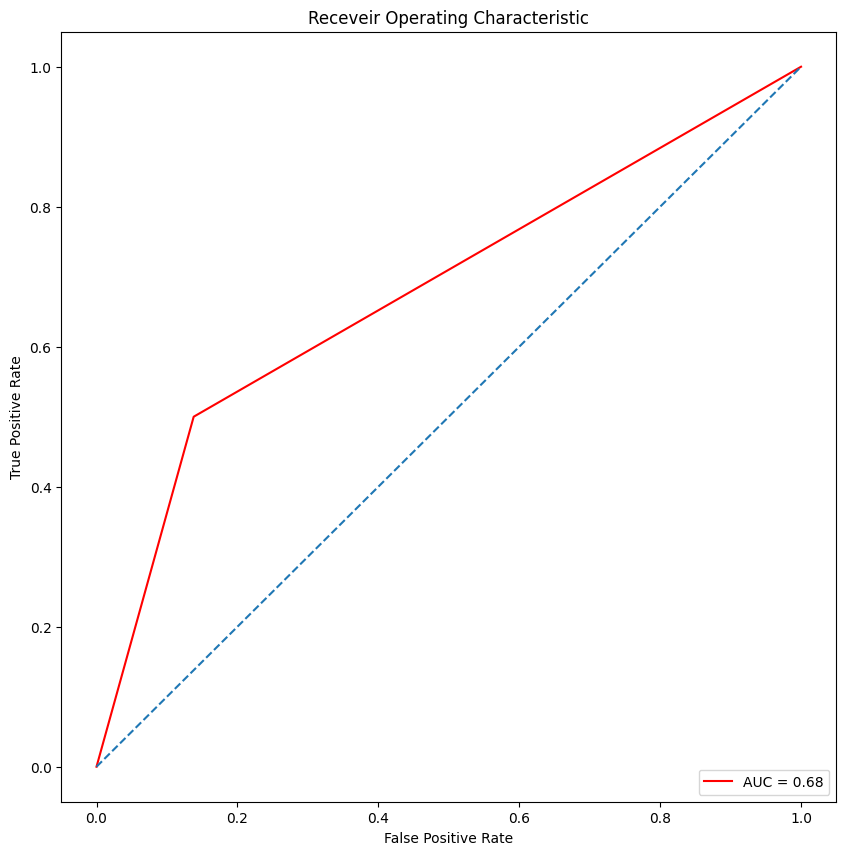

In [118]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.4 Decision trees

Better result without Normalization

In [173]:
estimator = DecisionTreeClassifier()

In [174]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [175]:
cv_results['test_score']

array([0.65680473, 0.69642857, 0.67261905])

In [176]:
cv_results['test_score'].mean()

0.67528411759181

In [177]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [178]:
sum(test_score) / len(test_score)

0.6842105263157894

In [179]:
score(estimator)

score train : 1.0 score test : 0.7719 


In [180]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [181]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,26,3
test_1,10,18


In [182]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7697044334975369

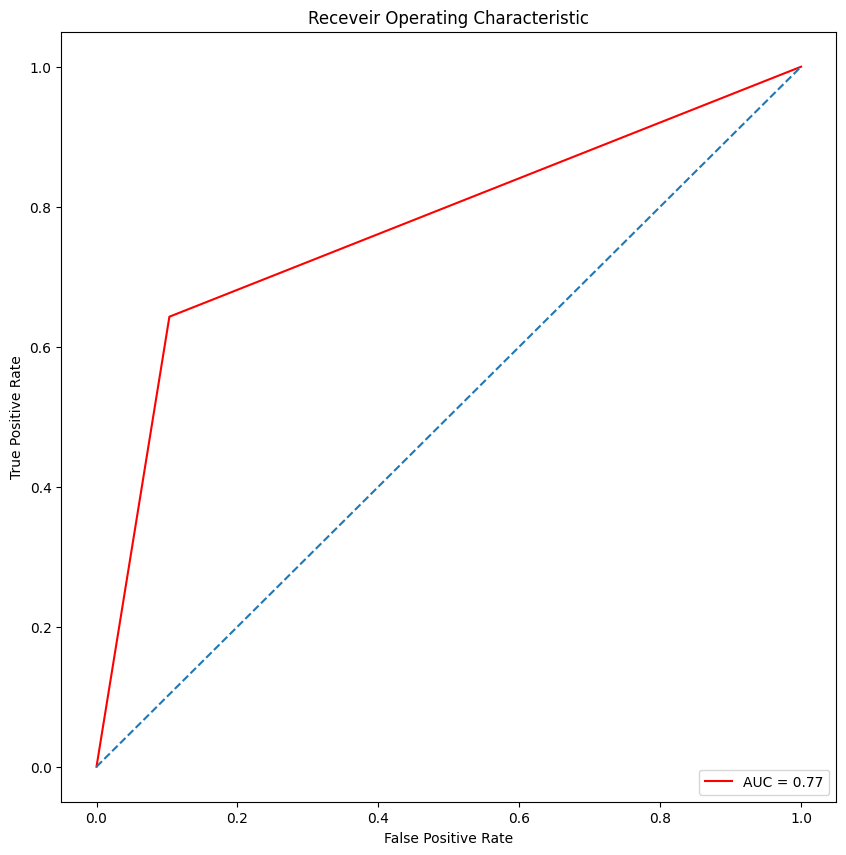

In [183]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.5 Random forest

Better result without Normalization

In [184]:
estimator = RandomForestClassifier()

In [185]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [186]:
cv_results['test_score']

array([0.69230769, 0.71428571, 0.75      ])

In [187]:
cv_results['test_score'].mean()

0.7188644688644689

In [188]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [189]:
sum(test_score) / len(test_score)

0.7777777777777777

In [190]:
score(estimator)

score train : 1.0 score test : 0.7719 


In [191]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [192]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,24,5
test_1,8,20


In [193]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.770935960591133

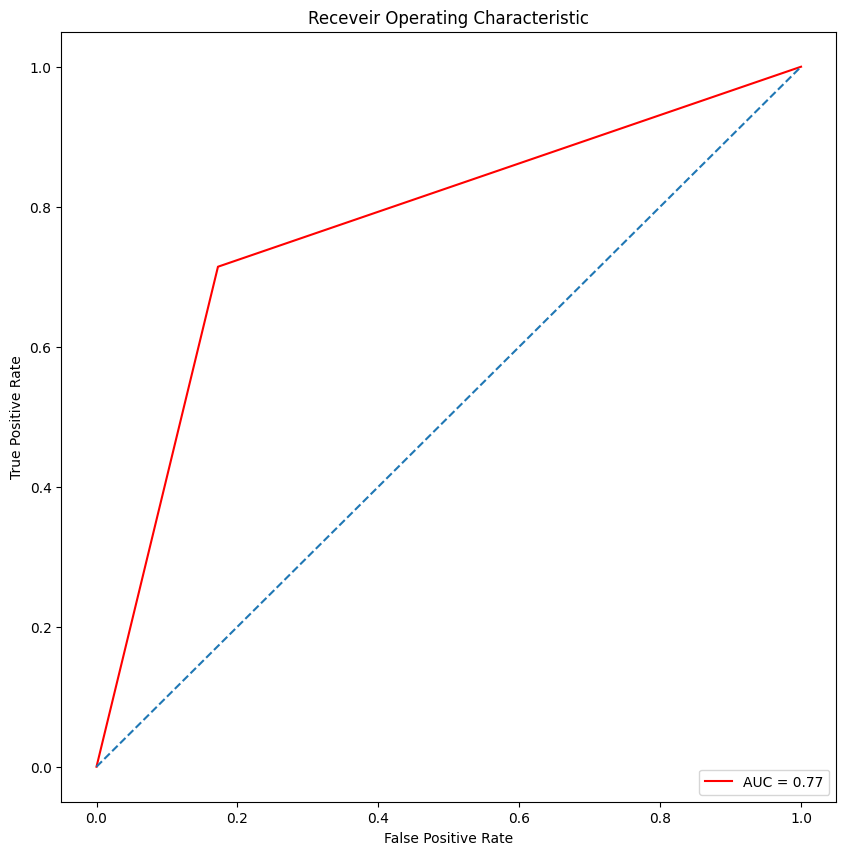

In [194]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.6 Naive Bayes

Better result without Normalization

In [195]:
estimator = GaussianNB()

In [196]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [197]:
cv_results['test_score']

array([0.65680473, 0.76190476, 0.72619048])

In [198]:
cv_results['test_score'].mean()

0.7149666572743496

In [199]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [200]:
sum(test_score) / len(test_score)

0.7543859649122807

In [201]:
score(estimator)

score train : 0.7149 score test : 0.7544 


In [202]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [203]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,21,8
test_1,6,22


In [204]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7549261083743841

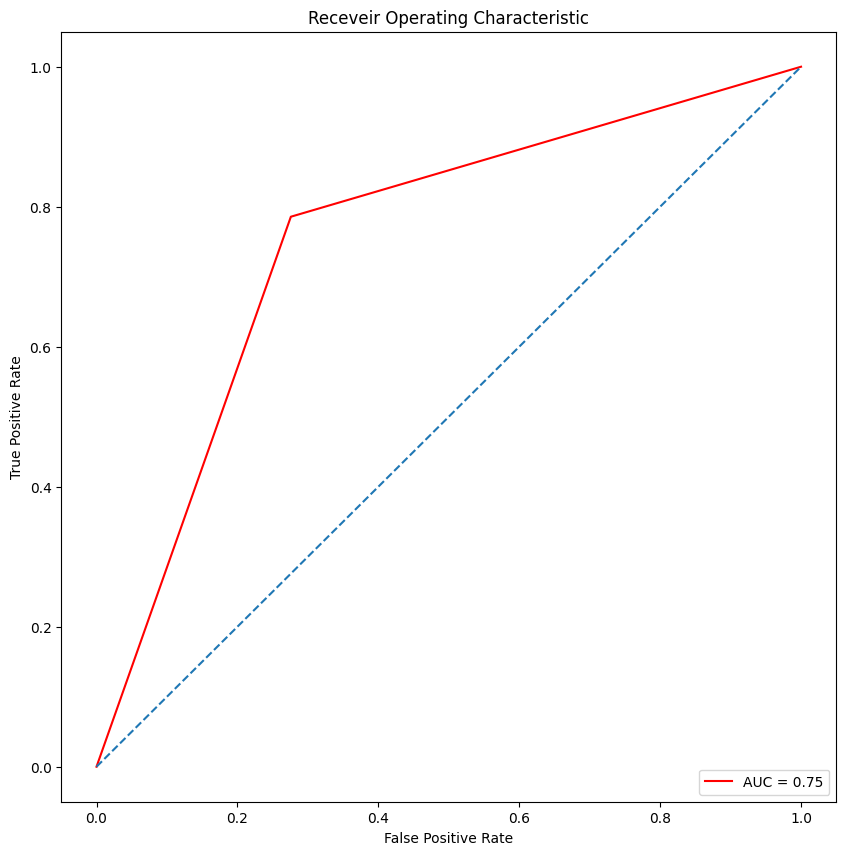

In [205]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.7 K-Nearest Neighbors

Better result after Normalization

In [151]:
estimator = KNeighborsClassifier()

In [152]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [153]:
cv_results['test_score']

array([0.66272189, 0.71428571, 0.71428571])

In [154]:
cv_results['test_score'].mean()

0.6970977740208509

In [155]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [156]:
sum(test_score) / len(test_score)

0.7192982456140351

In [157]:
score(estimator)

score train : 0.8198 score test : 0.6842 


In [158]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [159]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,23,6
test_1,12,16


In [160]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6822660098522167

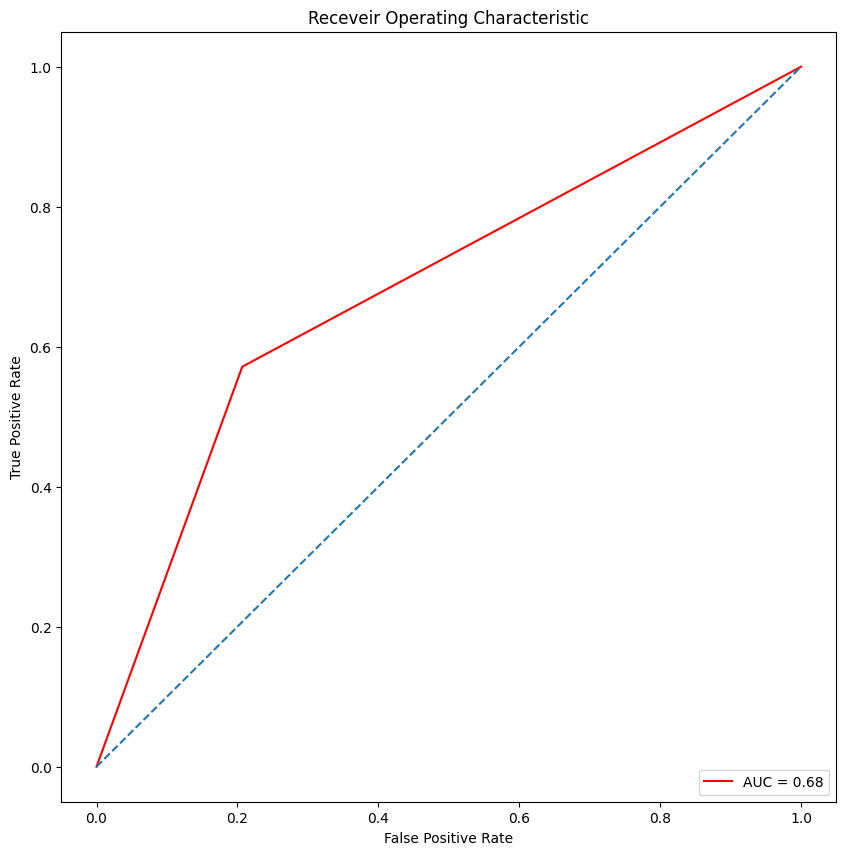

In [161]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()